In [1]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from mpi4py import MPI
from swe_2d import ShallowTwo

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
ds = xr.open_dataset("../data/Run07_G0_dt2.0_de0.5_ne5_velocity.nc")

print(ds)
print(ds.coords["y"])

u_spatial_average = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_average = np.mean(ds.V, axis=(1, 2, 3))

<xarray.Dataset>
Dimensions:  (time: 479, x: 64, y: 48, z: 32)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-14T21:13:04.390000 ... 2016-07-14T...
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 ... 0.3326 0.3379 0.3432
  * y        (y) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587
  * z        (z) float32 0.003 0.0045 0.006 0.0075 ... 0.045 0.0465 0.048 0.0495
Data variables:
    U        (time, x, y, z) float64 ...
    V        (time, x, y, z) float64 ...
    W        (time, x, y, z) float64 ...
Attributes: (12/38)
    Beta:                    83.33333333333336
    D:                       0.1
    Delta+:                  0.2066877575491193
    Delta_l:                 0.03883251825111399
    Delta_s:                 0.006180387232371034
    KC:                      11.439326702744928
    ...                      ...
    run_id:                  Run07
    source:                  3DPIV applied to Synthetic Aperture Imagery
    title:               

In [3]:
r = 0.05
print(478 * 64 * 48 * 32)

ds_zero = ds.isel(time=0)
ds_zero_missing = ds_zero.where(ds_zero.isnull(), drop=True)

x_missing = ds_zero_missing.coords["x"][:]
y_missing = ds_zero_missing.coords["y"][:]

print(x_missing, y_missing)

B = 1
L = 2
# find 
x_displacement = np.min(ds_zero.coords["x"][ds_zero.coords["x"] > np.max(x_missing)])
print(x_displacement)

46989312
<xarray.DataArray 'x' (x: 6)>
array([0.01056, 0.01584, 0.02112, 0.0264 , 0.03168, 0.03696], dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-14T21:13:04.390000
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 0.03168 0.03696 <xarray.DataArray 'y' (y: 17)>
array([0.09504, 0.10032, 0.1056 , 0.11088, 0.11616, 0.12144, 0.12672, 0.132  ,
       0.13728, 0.14256, 0.14784, 0.15312, 0.1584 , 0.16368, 0.16896, 0.17424,
       0.17952], dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-14T21:13:04.390000
  * y        (y) float32 0.09504 0.1003 0.1056 0.1109 ... 0.169 0.1742 0.1795
<xarray.DataArray 'x' ()>
array(0.04224, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-07-14T21:13:04.390000


In [18]:
output_file = "../outputs/branson-run-8-cn-test.h5"
outputs = h5py.File(output_file, "r")

coords = outputs["x"][:]
t = outputs["t"][:]
x, y = coords[:, 0], coords[:, 1]
u_out = outputs["u"][:]
v_out = outputs["v"][:]
outputs.close()

(50, 10553)
(10553,)
4.549999999999992


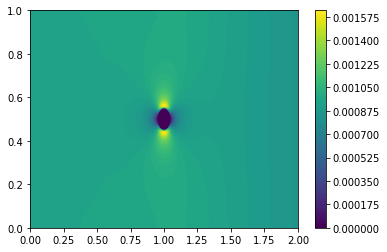

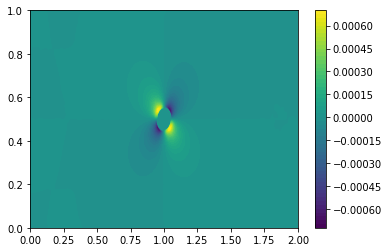

In [23]:
print(u_out.shape)
print(x.shape)

idx_plot = 45
print(t[idx_plot])
im = plt.tricontourf(x, y, u_out[idx_plot, :], 64)
plt.colorbar(im)
plt.show()

im = plt.tricontourf(x, y, v_out[idx_plot, :], 64)
plt.colorbar(im)
plt.show()

In [12]:
nt = 5000
nx_obs = 1
x_model_interp = np.array([[1. + 0.15, 0.55]])
print(x_model_interp)

subdomain_marker = fe.Expression(
    "x[0] >= 1.0 && x[0] <= 1.333 && x[1] >= 0.375 && x[1] <= 0.625 ? 1. : 0.", 
    degree=0)

vol = fe.assemble(subdomain_marker * fe.dx(domain=swe.mesh))
print(np.abs(0.333 * 0.25 - np.pi * 0.05**2 / 2 - vol))

t_obs = np.zeros((nt, ))
u_obs = np.zeros((nt, nx_obs))
u_ave = np.zeros((nt, nx_obs))
v_ave = np.zeros((nt, nx_obs))
for i in range(nt):
    vec_id = f"/du/vector_{i:d}"
    t_obs[i] = outputs.attributes(vec_id)["timestamp"]
    outputs.read(swe.du, vec_id)
    u, h = swe.du.split()
    u_obs[i, 0] = u(x_model_interp[0])[1]
    u_ave[i, 0] = fe.assemble(subdomain_marker * u.sub(0) * fe.dx) / vol
    v_ave[i, 0] = fe.assemble(subdomain_marker * u.sub(1) * fe.dx) / vol

[[1.15 0.55]]
2.9968936760993437e-05


In [13]:
u_spatial_average = u_spatial_average.assign_coords(
    dict(time_rel=((u_spatial_average["time"] 
                    - u_spatial_average["time"][0]) * 1e-9 - 80).astype(float)))

v_spatial_average = v_spatial_average.assign_coords(
    dict(time_rel=((v_spatial_average["time"]
                    - v_spatial_average["time"][0]) * 1e-9 - 80).astype(float)))

print(u_spatial_average)

<xarray.DataArray 'U' (time: 479)>
array([ 6.75983974e-03,  6.36040472e-03,  5.99752655e-03,  5.43456371e-03,
        4.56770508e-03,  3.58597175e-03,  2.61940707e-03,  1.64650453e-03,
        6.73809346e-04, -2.72561882e-04, -1.26598178e-03, -2.23472476e-03,
       -3.12387036e-03, -3.92552043e-03, -4.53264082e-03, -5.16212281e-03,
       -5.81070185e-03, -6.50570148e-03, -7.20530869e-03, -7.82878812e-03,
       -8.30979983e-03, -8.62567582e-03, -8.79002066e-03, -8.80275820e-03,
       -8.82469893e-03, -8.70225385e-03, -8.51280854e-03, -8.22915772e-03,
       -7.79236405e-03, -7.38802415e-03, -6.95329040e-03, -6.60370442e-03,
       -6.22205338e-03, -5.66753608e-03, -4.95416478e-03, -4.14774152e-03,
       -3.26367022e-03, -2.28746379e-03, -1.26738692e-03, -1.76320914e-04,
        9.39884040e-04,  1.90769601e-03,  2.71740763e-03,  3.51597226e-03,
        4.26557202e-03,  5.02307607e-03,  5.80395807e-03,  6.64153744e-03,
        7.35431183e-03,  7.94566656e-03,  8.37000715e-03,  8.6972

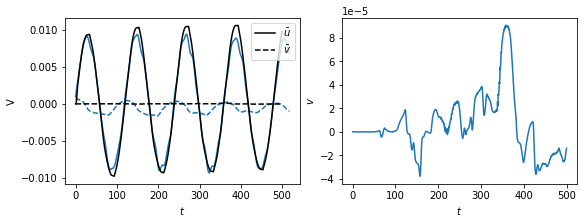

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
u_spatial_average.isel(time=range(40, 300)).plot(x="time_rel", ax=axs[0])
v_spatial_average.isel(time=range(40, 300)).plot(x="time_rel", ax=axs[0], color="tab:blue", ls="--")

axs[0].plot(
    t_obs,  u_ave, 
    ls="-", color="black", label=r"$\bar u$")
axs[0].plot(
    t_obs, v_ave, 
    ls="--", color="black", label=r"$\bar v$")
axs[0].legend()

axs[1].plot(t_obs, v_ave)
axs[1].set_ylabel(r"$v$")

for ax in axs:
    ax.set_xlabel(r"$t$")
    
plt.show()